In [2]:
!pip install plotly

In [3]:


from pyspark.sql import SparkSession,Window
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col,desc, asc, expr,avg,count,countDistinct,lag,round
import os

# Create a Spark session that will allow to connect to a SQlite JDBC and read the document

In [4]:
spark = (SparkSession.builder
    .master("local")
    .appName("SQLite JDBC")
    .config(
        "spark.jars",
        "/Users/derib/data_architecture/sqlite-jdbc-3.34.0.jar".format(os.getcwd()))
    .config(
        "spark.driver.extraClassPath",
        "/Users/derib/data_architecture/sqlite-jdbc-3.34.0.jar".format(os.getcwd()))
    .getOrCreate())
spark

25/04/12 18:19:06 WARN Utils: Your hostname, MacBook-Pro-de-de.local resolves to a loopback address: 127.0.0.1; using 192.168.1.17 instead (on interface en0)
25/04/12 18:19:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/04/12 18:19:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Read the different table from the pay_gap_data_normalized

In [5]:
df_country = spark.read.jdbc(url='jdbc:sqlite://Users/derib/data_architecture/tp1/pay_gap_data_normalized.db',table="Country")
df_sector = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp1/pay_gap_data_normalized.db',table="Sector")
df_sector_data = spark.read.jdbc(url='jdbc:sqlite:/Users/derib/data_architecture/tp1/pay_gap_data_normalized.db',table="CountrySectorData")


In [6]:
df_country = df_country.dropna()
df_sector = df_sector.dropna()
df_sector_data = df_sector_data.dropna()

## Join the different tables

In [7]:
df_all = df_sector_data.join(df_country, on="country_id", how="inner")



In [8]:
df_all_merge = df_all.join(df_sector, on=["sector_id"], how="inner")

In [9]:
df_all_merge.show(5)

+---------+----------+---+----+-----+------------+-----------+
|sector_id|country_id| id|year|value|country_name|sector_name|
+---------+----------+---+----+-----+------------+-----------+
|        1|         1|  1|2010| 24.0|     Austria|   Industry|
|        1|         1| 20|2011| 23.5|     Austria|   Industry|
|        1|         1| 22|2012| 22.9|     Austria|   Industry|
|        1|         1| 24|2013| 22.3|     Austria|   Industry|
|        1|         1| 26|2014| 22.2|     Austria|   Industry|
+---------+----------+---+----+-----+------------+-----------+
only showing top 5 rows



In [10]:
df_all_merge.describe().show()

25/04/12 18:19:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+------------------+------------+-------------+
|summary|        sector_id|        country_id|                id|              year|             value|country_name|  sector_name|
+-------+-----------------+------------------+------------------+------------------+------------------+------------+-------------+
|  count|            49832|             49832|             49832|             49832|             49832|       49832|        49832|
|   mean|10.45561085246428|14.233424305667041|           24916.5|2015.5740889388344| 13.55509712634447|        NULL|         NULL|
| stddev|5.769049240960093| 7.742422788992127|14385.403643971933|3.4564592441207282|10.958289702743132|        NULL|         NULL|
|    min|                1|                 1|                 1|              2010|             -47.9|     Austria|Accommodation|
|    max|               20|                27|             49832|              2021

### Drop the not useful columns and the duplicates

In [11]:
df_all_merge = df_all_merge.drop("id")
df_all_merge = df_all_merge.dropDuplicates()

### Count the number of country

In [12]:

df_all_merge.select(countDistinct("country_id")).show()

+--------------------------+
|count(DISTINCT country_id)|
+--------------------------+
|                        27|
+--------------------------+



### Count the number of year

In [13]:
df_all_merge.select(countDistinct("year")).show()

+--------------------+
|count(DISTINCT year)|
+--------------------+
|                  12|
+--------------------+



### Display the values for the country austria

In [14]:
df_all_merge.where(df_all_merge["country_name"] == "Austria").show()

+---------+----------+----+-----+------------+-----------+
|sector_id|country_id|year|value|country_name|sector_name|
+---------+----------+----+-----+------------+-----------+
|        1|         1|2010| 24.0|     Austria|   Industry|
|        1|         1|2011| 23.5|     Austria|   Industry|
|        1|         1|2012| 22.9|     Austria|   Industry|
|        1|         1|2013| 22.3|     Austria|   Industry|
|        1|         1|2014| 22.2|     Austria|   Industry|
|        1|         1|2015| 21.8|     Austria|   Industry|
|        1|         1|2016| 20.8|     Austria|   Industry|
|        1|         1|2017| 20.7|     Austria|   Industry|
|        1|         1|2018| 20.4|     Austria|   Industry|
|        1|         1|2019| 19.9|     Austria|   Industry|
|        1|         1|2020| 18.9|     Austria|   Industry|
|        1|         1|2021| 18.8|     Austria|   Industry|
|        2|         1|2010| 25.2|     Austria|   Business|
|        2|         1|2011| 24.7|     Austria|   Busines

In [15]:
#Select two first columns
df_all_merge.select(df_all_merge.columns[:2]).show(10) 

+---------+----------+
|sector_id|country_id|
+---------+----------+
|        1|         1|
|        1|         1|
|        1|         1|
|        1|         1|
|        1|         1|
|        1|         1|
|        1|         1|
|        1|         1|
|        1|         1|
|        1|         1|
+---------+----------+
only showing top 10 rows



### Display the values for the country Austria and the sector name Industry

In [16]:
df_all_merge.where((col("country_name") == "Austria") & (col("sector_name")=="Industry")).show()

+---------+----------+----+-----+------------+-----------+
|sector_id|country_id|year|value|country_name|sector_name|
+---------+----------+----+-----+------------+-----------+
|        1|         1|2010| 24.0|     Austria|   Industry|
|        1|         1|2011| 23.5|     Austria|   Industry|
|        1|         1|2012| 22.9|     Austria|   Industry|
|        1|         1|2013| 22.3|     Austria|   Industry|
|        1|         1|2014| 22.2|     Austria|   Industry|
|        1|         1|2015| 21.8|     Austria|   Industry|
|        1|         1|2016| 20.8|     Austria|   Industry|
|        1|         1|2017| 20.7|     Austria|   Industry|
|        1|         1|2018| 20.4|     Austria|   Industry|
|        1|         1|2019| 19.9|     Austria|   Industry|
|        1|         1|2020| 18.9|     Austria|   Industry|
|        1|         1|2021| 18.8|     Austria|   Industry|
+---------+----------+----+-----+------------+-----------+



### display the number of entry by year

In [17]:
df_all_merge.groupby("year").count().sort("count").show()

+----+-----+
|year|count|
+----+-----+
|2012|  484|
|2011|  485|
|2015|  505|
|2013|  505|
|2016|  526|
|2017|  526|
|2014|  532|
|2019|  533|
|2020|  533|
|2010|  533|
|2021|  533|
|2018|  534|
+----+-----+



### Display the number of entry by country

In [18]:
df_all_merge.groupby(["country_name"]).count().sort("country_name").show()

+--------------+-----+
|  country_name|count|
+--------------+-----+
|       Austria|  177|
|       Belgium|  228|
|      Bulgaria|  240|
|       Croatia|  179|
|        Cyprus|  240|
|Czech Republic|  240|
|       Denmark|  240|
|       Estonia|  240|
|       Finland|  240|
|        France|  240|
|       Germany|  240|
|       Hungary|  239|
|         Italy|  180|
|        Latvia|  236|
|     Lithuania|  240|
|    Luxembourg|  221|
|         Malta|  222|
|   Netherlands|  240|
|        Norway|  239|
|        Poland|  240|
+--------------+-----+
only showing top 20 rows



### SelectExpr vs Select

### Select the country, the country id, the value, and create a new column that will multiple by 100 the column value

In [19]:
df_all_merge.select(col("country_name"),col("country_id"),col("value"),(col("value")*100).alias("valueBy100")).show()

+------------+----------+-----+------------------+
|country_name|country_id|value|        valueBy100|
+------------+----------+-----+------------------+
|     Austria|         1| 24.0|            2400.0|
|     Austria|         1| 23.5|            2350.0|
|     Austria|         1| 22.9|            2290.0|
|     Austria|         1| 22.3|            2230.0|
|     Austria|         1| 22.2|            2220.0|
|     Austria|         1| 21.8|            2180.0|
|     Austria|         1| 20.8|            2080.0|
|     Austria|         1| 20.7|            2070.0|
|     Austria|         1| 20.4|2039.9999999999998|
|     Austria|         1| 19.9|1989.9999999999998|
|     Austria|         1| 18.9|1889.9999999999998|
|     Austria|         1| 18.8|            1880.0|
|     Belgium|         2| 10.2|1019.9999999999999|
|     Belgium|         2|  9.4|             940.0|
|     Belgium|         2|  8.3| 830.0000000000001|
|     Belgium|         2|  7.5|             750.0|
|     Belgium|         2|  6.6|

### Same than above but with expr

In [20]:
df_all_merge.selectExpr("country_name","country_id","value","value*100 as valueBy100").show()

+------------+----------+-----+------------------+
|country_name|country_id|value|        valueBy100|
+------------+----------+-----+------------------+
|     Austria|         1| 24.0|            2400.0|
|     Austria|         1| 23.5|            2350.0|
|     Austria|         1| 22.9|            2290.0|
|     Austria|         1| 22.3|            2230.0|
|     Austria|         1| 22.2|            2220.0|
|     Austria|         1| 21.8|            2180.0|
|     Austria|         1| 20.8|            2080.0|
|     Austria|         1| 20.7|            2070.0|
|     Austria|         1| 20.4|2039.9999999999998|
|     Austria|         1| 19.9|1989.9999999999998|
|     Austria|         1| 18.9|1889.9999999999998|
|     Austria|         1| 18.8|            1880.0|
|     Belgium|         2| 10.2|1019.9999999999999|
|     Belgium|         2|  9.4|             940.0|
|     Belgium|         2|  8.3| 830.0000000000001|
|     Belgium|         2|  7.5|             750.0|
|     Belgium|         2|  6.6|

### Display the average of the gender pay gap

### Some functions

In [21]:
df_all_merge.select(avg(col("value"))).show()

+------------------+
|        avg(value)|
+------------------+
|13.555097126344545|
+------------------+



### Dsiplay the sum of all value for total year and sector for a country

In [22]:
df_all_merge.groupby("country_name").sum("value").show()

+--------------+------------------+
|  country_name|        sum(value)|
+--------------+------------------+
|        Sweden|2037.1999999999996|
|       Germany|            4259.4|
|        France|            3128.4|
|      Slovakia|            3701.8|
|       Belgium|1762.6000000000004|
|       Finland|3571.8000000000006|
|         Malta| 3334.299999999998|
|       Croatia|1801.3000000000009|
|         Italy|2623.3000000000006|
|     Lithuania|3432.5000000000014|
|        Norway|2914.0999999999995|
|         Spain|3184.9999999999995|
|       Denmark|2941.0999999999985|
|        Cyprus| 4358.299999999998|
|       Estonia| 5141.999999999999|
|   Switzerland|3970.9999999999995|
|        Latvia| 3919.600000000002|
|Czech Republic| 4346.499999999997|
|      Slovenia|1653.5999999999995|
|    Luxembourg| 2376.599999999998|
+--------------+------------------+
only showing top 20 rows



### Between

In [23]:
df_all_merge.select(col("country_name"),col("value")).where(col("value").between(30,40)).sort(col("value").desc()).show()

+--------------+-----+
|  country_name|value|
+--------------+-----+
|     Lithuania| 40.0|
|     Lithuania| 39.9|
|     Lithuania| 39.9|
|   Netherlands| 39.7|
|Czech Republic| 39.5|
|        Cyprus| 39.4|
|Czech Republic| 39.0|
|Czech Republic| 38.9|
|       Hungary| 38.7|
|       Hungary| 38.6|
|       Estonia| 38.5|
|        Poland| 38.5|
|       Estonia| 38.3|
|Czech Republic| 38.2|
|      Portugal| 38.2|
|       Estonia| 38.0|
|       Hungary| 38.0|
|       Hungary| 38.0|
|      Slovakia| 38.0|
|        Cyprus| 38.0|
+--------------+-----+
only showing top 20 rows



### Create a partition to see the calculate the lag between year and sector in gender gap

In [24]:
w = Window.partitionBy(["country_name","sector_name"]).orderBy("year")


In [25]:
country_increment = df_all_merge.withColumn("previous_gap", lag("value").over(w))
country_increment.withColumn("changed_gap", country_increment.value - country_increment.previous_gap).na.fill(value=0).sort(col("changed_gap").desc()).show(truncate=False)

+---------+----------+----+-----+------------+--------------+------------+------------------+
|sector_id|country_id|year|value|country_name|sector_name   |previous_gap|changed_gap       |
+---------+----------+----+-----+------------+--------------+------------+------------------+
|19       |13        |2014|61.3 |Italy       |Arts          |20.4        |40.9              |
|3        |12        |2017|5.1  |Hungary     |Mining        |-22.3       |27.4              |
|3        |17        |2018|28.9 |Malta       |Mining        |1.7         |27.2              |
|3        |13        |2014|6.6  |Italy       |Mining        |-15.2       |21.799999999999997|
|12       |4         |2017|24.9 |Croatia     |Financial     |4.9         |20.0              |
|6        |21        |2019|-14.2|Portugal    |Water_supply  |-33.2       |19.000000000000004|
|3        |23        |2013|10.0 |Slovakia    |Mining        |-8.2        |18.2              |
|15       |4         |2017|3.5  |Croatia     |Administrative

### Display the four most gender_pay gap countries in average

In [26]:

df_all_merge.groupby("country_name").agg(expr("avg(value) as total_value")).sort(col("total_value").desc()).show(4)

+--------------+------------------+
|  country_name|       total_value|
+--------------+------------------+
|       Estonia|21.424999999999997|
|       Austria|19.233898305084765|
|        Cyprus|18.159583333333327|
|Czech Republic|18.110416666666655|
+--------------+------------------+
only showing top 4 rows



### Display using the selectExpr everything where value is more than 20 and add a column for a boolean value for this

In [27]:

(df_all_merge.selectExpr(
   "*", # all original columns
   "(value > 20) as HighValueItem")
   .show()
)


+---------+----------+----+-----+------------+-----------+-------------+
|sector_id|country_id|year|value|country_name|sector_name|HighValueItem|
+---------+----------+----+-----+------------+-----------+-------------+
|        1|         1|2010| 24.0|     Austria|   Industry|         true|
|        1|         1|2011| 23.5|     Austria|   Industry|         true|
|        1|         1|2012| 22.9|     Austria|   Industry|         true|
|        1|         1|2013| 22.3|     Austria|   Industry|         true|
|        1|         1|2014| 22.2|     Austria|   Industry|         true|
|        1|         1|2015| 21.8|     Austria|   Industry|         true|
|        1|         1|2016| 20.8|     Austria|   Industry|         true|
|        1|         1|2017| 20.7|     Austria|   Industry|         true|
|        1|         1|2018| 20.4|     Austria|   Industry|         true|
|        1|         1|2019| 19.9|     Austria|   Industry|        false|
|        1|         1|2020| 18.9|     Austria|   In

## Exercice to do

In [ ]:
#select the columns value and year
df_all_merge.select("year","value").show(10)

In [ ]:
# select the single column sector_name and display the distinct values
df_all_merge.select("sector_name").distinct().show(5)

+------------------+
|       sector_name|
+------------------+
|      Human_health|
|         Education|
|Electricity_supply|
|    Administrative|
|       Information|
+------------------+
only showing top 5 rows



In [42]:
# add a new column that will contains the year + 1 year for each row
df_all_merge.withColumn("next_year", expr("year + 1")).show(5)

+---------+----------+----+-----+------------+-----------+---------+
|sector_id|country_id|year|value|country_name|sector_name|next_year|
+---------+----------+----+-----+------------+-----------+---------+
|        1|         1|2010| 24.0|     Austria|   Industry|     2011|
|        1|         1|2011| 23.5|     Austria|   Industry|     2012|
|        1|         1|2012| 22.9|     Austria|   Industry|     2013|
|        1|         1|2013| 22.3|     Austria|   Industry|     2014|
|        1|         1|2014| 22.2|     Austria|   Industry|     2015|
+---------+----------+----+-----+------------+-----------+---------+
only showing top 5 rows



In [ ]:
# select the value for belgium and year 2015 and sector_name "Industry"
df_all_merge.select("value").where((col("country_name") == "Belgium") & (col("year") == 2015) & (col("sector_name") == "Industry")).show(5)



+-----+
|value|
+-----+
|  6.4|
+-----+



In [ ]:
# Display all for Belgium or Switzerland for year 2015 and sector_name "Arts"
df_all_merge.select("*").where(((col("country_name") == "Belgium") | (col("country_name") == "Switzerland")) & (col("year") == 2015) & (col("sector_name")=="Arts")).show(15)

+---------+----------+----+-----+------------+-----------+
|sector_id|country_id|year|value|country_name|sector_name|
+---------+----------+----+-----+------------+-----------+
|       19|         2|2015|  1.1|     Belgium|       Arts|
|       19|        27|2015| 13.5| Switzerland|       Arts|
+---------+----------+----+-----+------------+-----------+



In [49]:
# select the average value, the minimum value and the maximum value for all countries and all sectors
from pyspark.sql.functions import avg, max, min
( df_all_merge.select(
    avg("value").alias("average_value"),
    max("value").alias("max_value"),
    min("value").alias("min_value"))
   .show()
)

+------------------+---------+---------+
|     average_value|max_value|min_value|
+------------------+---------+---------+
|13.555097126344545|     68.6|    -47.9|
+------------------+---------+---------+



In [50]:
# select the average value, and the stddev for all countries and the sectors grouped together
df_all_merge.groupBy("country_name").agg(expr("avg(value)"),expr("stddev_pop(value)"))\
  .show(30)

+--------------+------------------+------------------+
|  country_name|        avg(value)| stddev_pop(value)|
+--------------+------------------+------------------+
|        Sweden| 8.488333333333332| 6.749298523221176|
|       Germany|           17.7475| 8.455555003467644|
|        France|            13.035| 8.790583503575478|
|      Slovakia|15.424166666666668|10.758880020966663|
|       Belgium| 7.730701754385967| 6.778773982109397|
|       Finland|14.882500000000002| 6.572679089737054|
|         Malta| 15.01936936936936| 8.672356079097845|
|       Croatia|10.063128491620116|10.812773495244757|
|         Italy|14.573888888888892|10.683525031503667|
|     Lithuania| 14.30208333333334|10.699129434665338|
|        Norway|  12.1928870292887| 7.388874908820689|
|         Spain|13.270833333333332| 8.429787421532183|
|       Denmark|12.254583333333327| 5.594757575301087|
|        Cyprus|18.159583333333327|15.990804383344479|
|       Estonia|21.424999999999997| 9.440138152237669|
|   Switze

# Change to pandas to do some visualisation

In [30]:
df_all_pandas = df_all_merge.toPandas()
df_all_pandas

,sector_id,country_id,year,value,country_name,sector_name
0,1,1,2010,24.0,Austria,Industry
1,1,1,2011,23.5,Austria,Industry
2,1,1,2012,22.9,Austria,Industry
3,1,1,2013,22.3,Austria,Industry
4,1,1,2014,22.2,Austria,Industry
...,...,...,...,...,...,...
6224,10,27,2016,7.3,Switzerland,Accommodation
6225,18,14,2020,22.9,Latvia,Human_health
6226,20,11,2015,20.4,Germany,Other
6227,20,17,2013,1.0,Malta,Other


In [31]:
df_for_visu = df_all_pandas.drop(columns=["country_name","sector_name"])

In [32]:
df_for_visu

,sector_id,country_id,year,value
0,1,1,2010,24.0
1,1,1,2011,23.5
2,1,1,2012,22.9
3,1,1,2013,22.3
4,1,1,2014,22.2
...,...,...,...,...
6224,10,27,2016,7.3
6225,18,14,2020,22.9
6226,20,11,2015,20.4
6227,20,17,2013,1.0


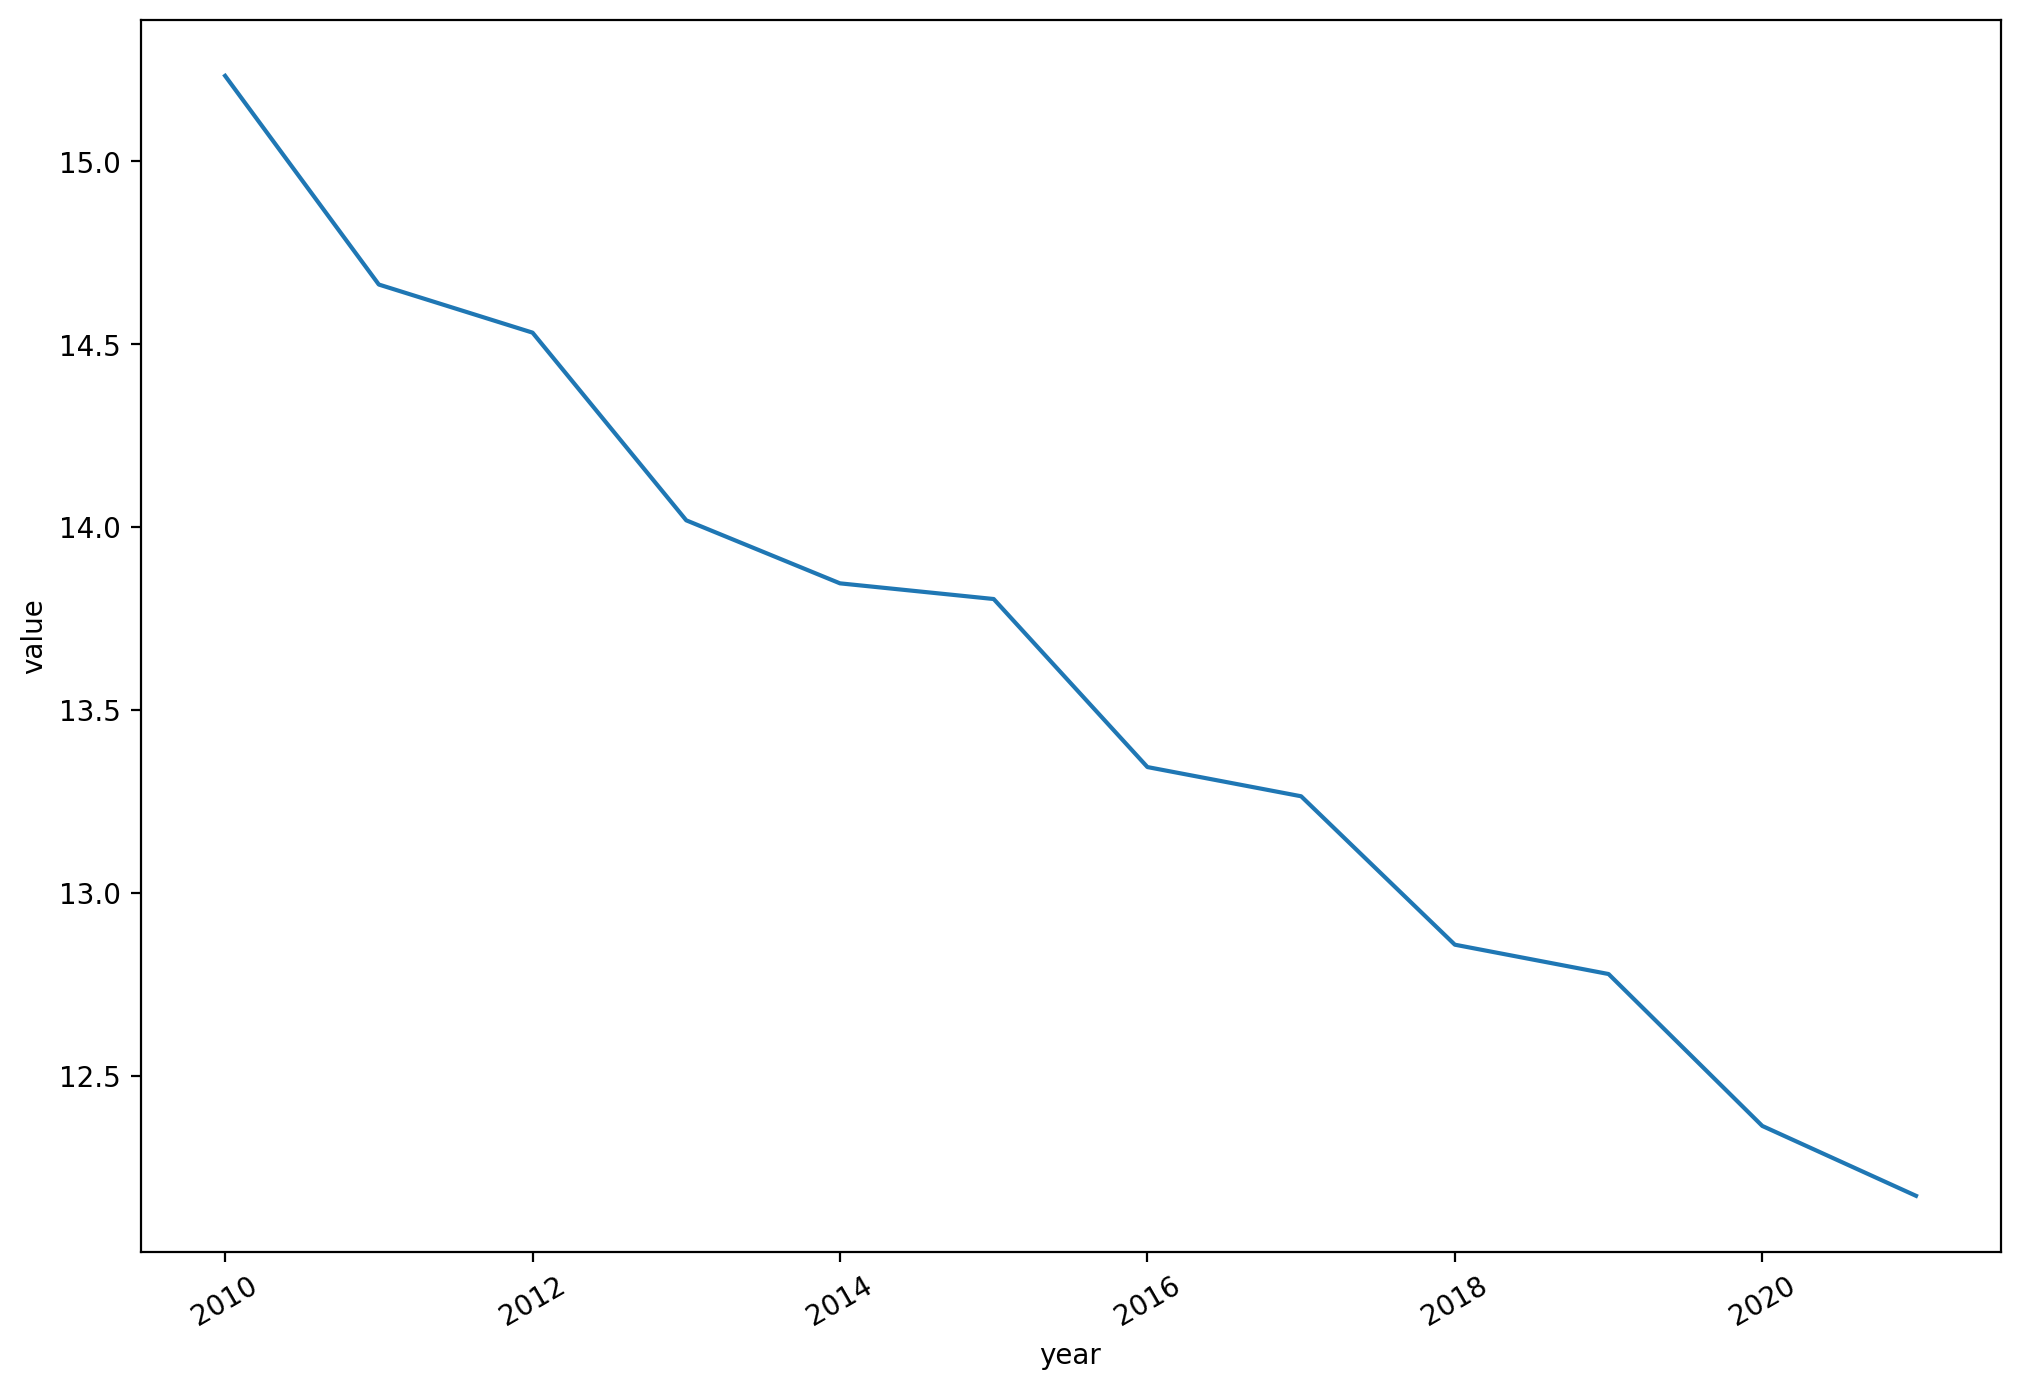

In [33]:
df_G  = df_for_visu.groupby(["year"])["value"].mean()

plt.figure(figsize=(12, 8), dpi=200)
sns.lineplot(data=df_G)
plt.xticks(rotation=30)
plt.show()



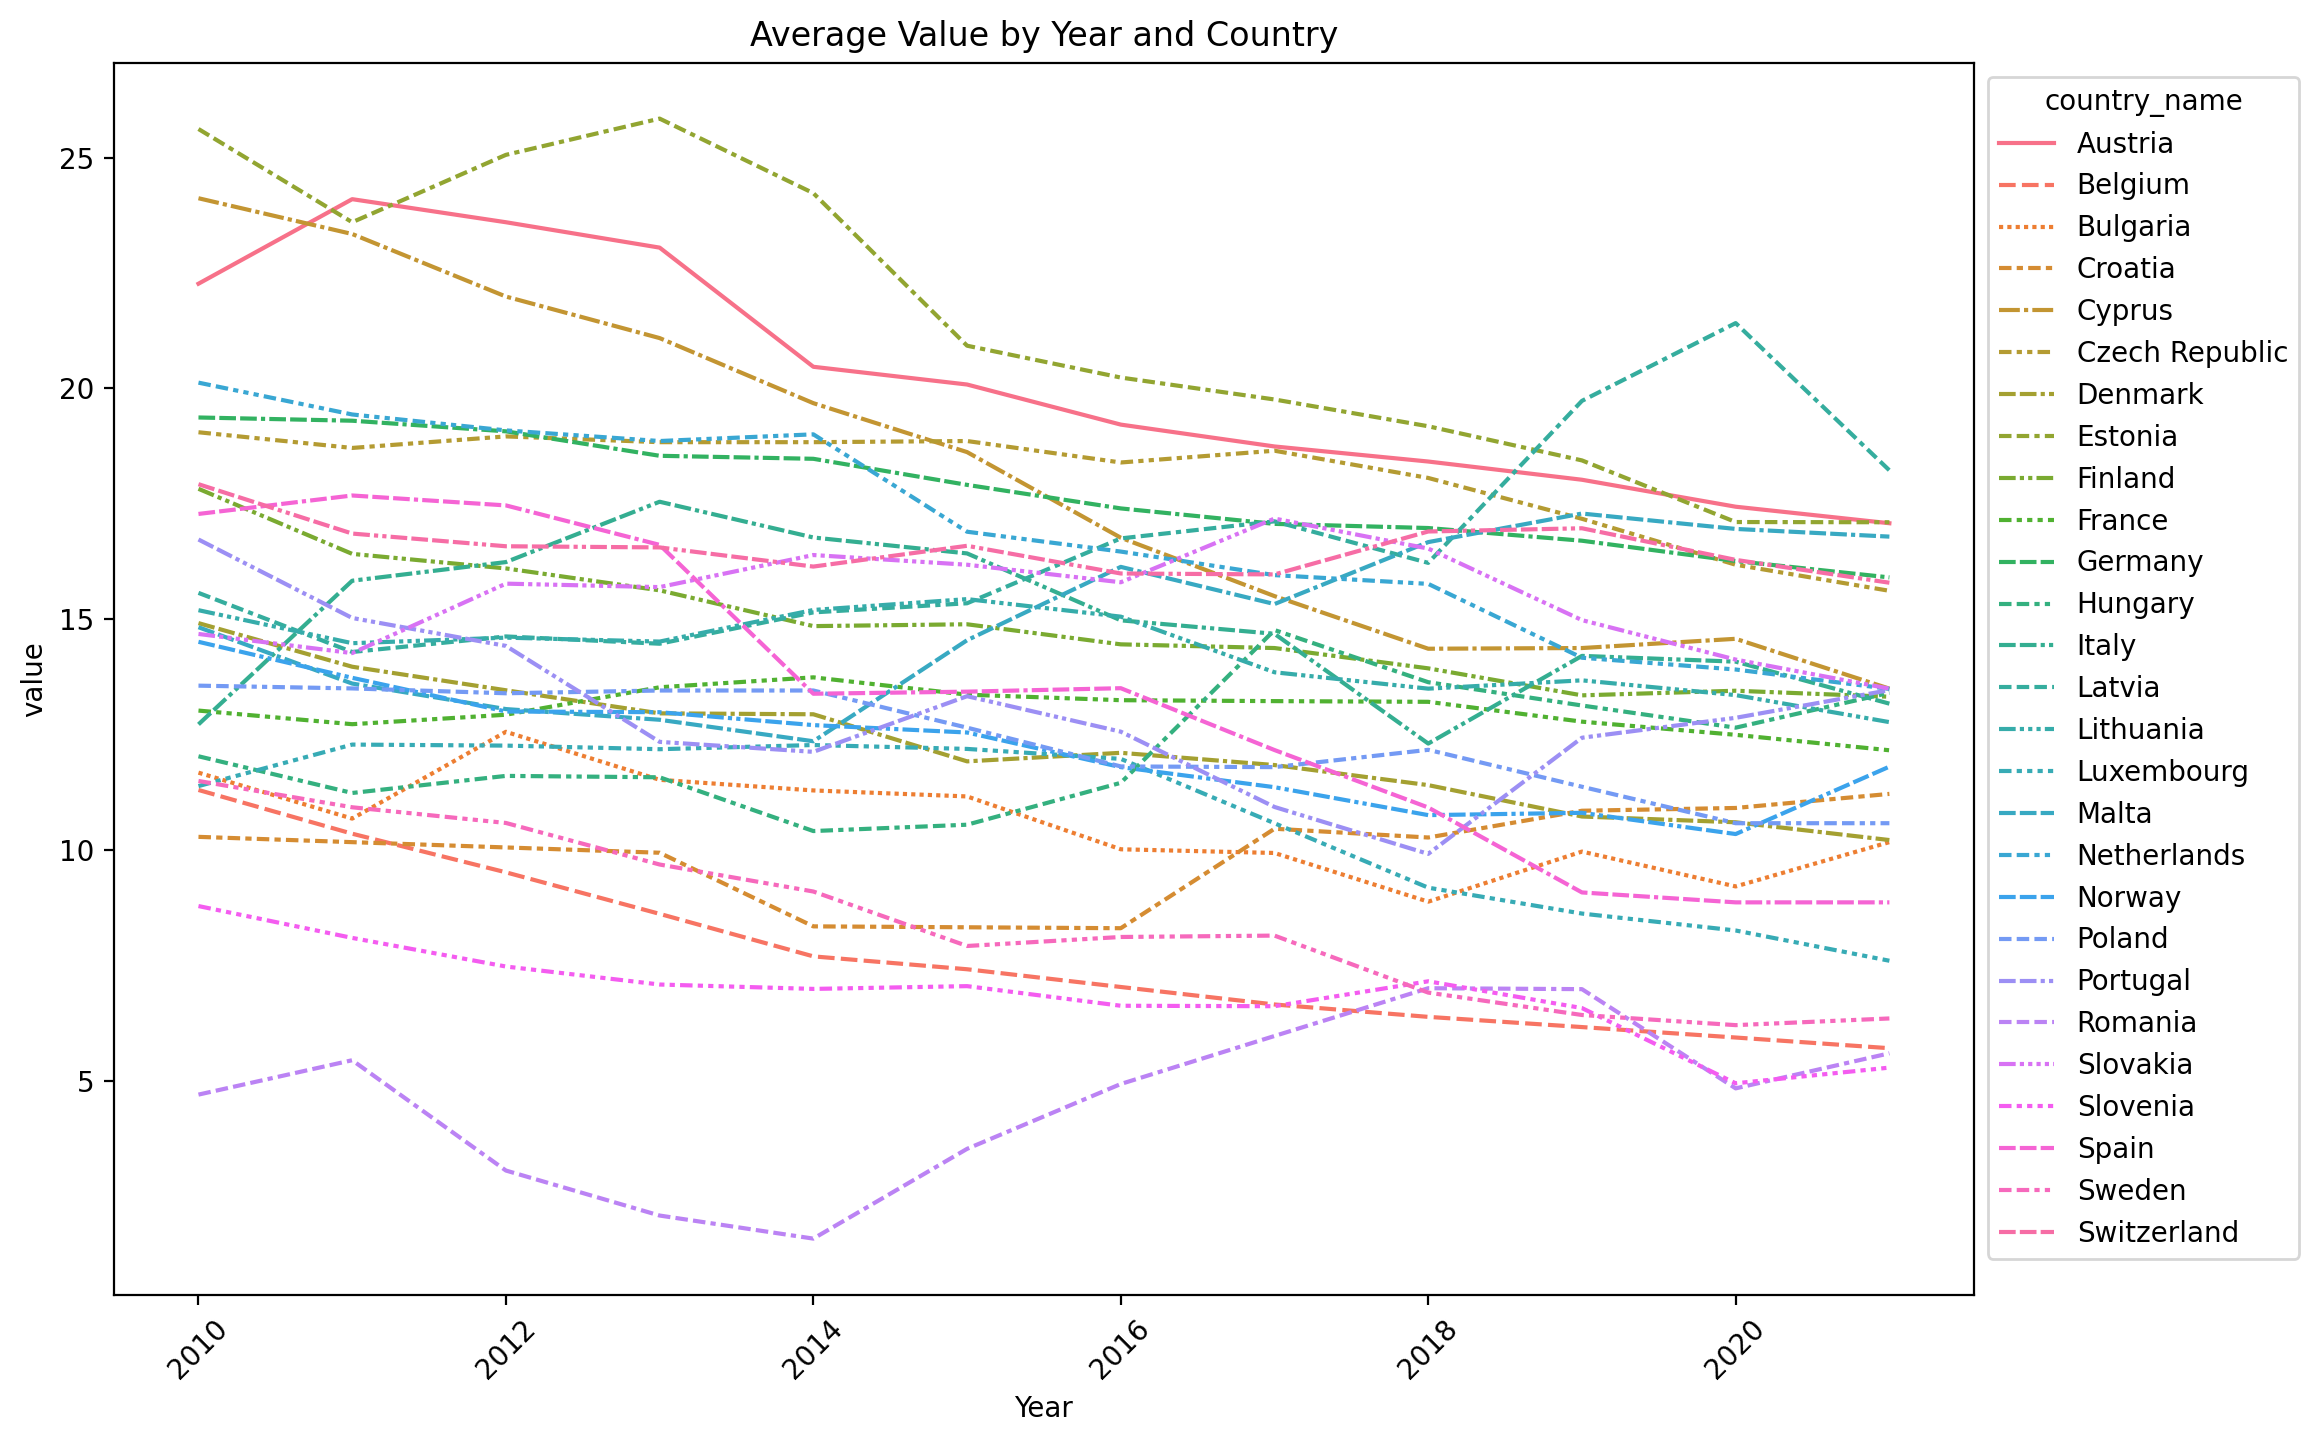

In [34]:
# Group by sector and country, then calculate the mean of the value
df_avg = df_all_pandas.groupby(["year", "country_name"])["value"].mean().reset_index()

# Create a pivot table for better visualization
df_pivot = df_avg.pivot(index="year", columns="country_name", values="value")

# Plot a heatmap
plt.figure(figsize=(12, 8), dpi=200)
ax = sns.lineplot(df_pivot)
plt.title("Average Value by Year and Country")
plt.xlabel("Year")
plt.ylabel("value")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()